In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create folder to save signals
os.makedirs("signals", exist_ok=True)

# Signal generator functions
def generate_healthy_signal(length=1000, freq=50, noise=0.05):
    t = np.linspace(0, 1, length)
    signal = np.sin(2 * np.pi * freq * t) + noise * np.random.randn(length)
    return t, signal

def generate_broken_rotor_signal(length=1000, freq=50, noise=0.05):
    t = np.linspace(0, 1, length)
    modulator = 1 + 0.3 * np.sin(2 * np.pi * 5 * t)
    signal = modulator * np.sin(2 * np.pi * freq * t) + noise * np.random.randn(length)
    return t, signal

def generate_bearing_fault_signal(length=1000, freq=50, noise=0.05):
    t = np.linspace(0, 1, length)
    bursts = np.zeros(length)
    bursts[200:210] = 1
    bursts[500:510] = 1
    bursts[750:760] = 1
    signal = np.sin(2 * np.pi * freq * t) + 0.6 * bursts + noise * np.random.randn(length)
    return t, signal

def generate_combined_fault_signal(length=1000, freq=50, noise=0.05):
    t = np.linspace(0, 1, length)
    modulator = 1 + 0.3 * np.sin(2 * np.pi * 5 * t)
    bursts = np.zeros(length)
    bursts[300:310] = 1
    bursts[600:610] = 1
    signal = modulator * np.sin(2 * np.pi * freq * t) + 0.6 * bursts + noise * np.random.randn(length)
    return t, signal

def generate_sensor_fault_signal(length=1000, freq=50, noise=0.5):
    t = np.linspace(0, 1, length)
    signal = np.sin(2 * np.pi * freq * t) + noise * np.random.randn(length)
    return t, signal

# Save signals and plots
def plot_and_save(t, signal, title, filename):
    plt.figure(figsize=(10, 3))
    plt.plot(t, signal)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"signals/{filename}")
    plt.close()

# Generate signals
signals = {
    "healthy": generate_healthy_signal(),
    "broken_rotor": generate_broken_rotor_signal(),
    "bearing_fault": generate_bearing_fault_signal(),
    "combined_fault": generate_combined_fault_signal(),
    "sensor_noise": generate_sensor_fault_signal()
}

# Save all
for label, (t, signal) in signals.items():
    plot_and_save(t, signal, f"{label.replace('_', ' ').title()} Signal", f"{label}.png")
    np.save(f"signals/{label}.npy", signal)

print("✅ All signals generated and saved.")

✅ All signals generated and saved.


In [2]:
!pip install PyWavelets

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os

# Create output folder
os.makedirs("scalograms", exist_ok=True)

# Set wavelet and scales
wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet
scales = np.arange(1, 64)

# Function to generate and save scalogram
def create_scalogram(signal, label, index):
    coef, freqs = pywt.cwt(signal, scales, wavelet)
    power = np.abs(coef)

    plt.figure(figsize=(5, 4))
    plt.imshow(power, extent=[0, 1, 1, 64], cmap='jet', aspect='auto', origin='lower')
    plt.axis('off')
    filename = f"scalograms/{label}_{index}.png"
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()
    return filename

# Load signals from saved .npy files
labels = ["healthy", "broken_rotor", "bearing_fault", "combined_fault", "sensor_noise"]

count = 0
for label in labels:
    signal = np.load(f"signals/{label}.npy")
    for i in range(6):  # Generate multiple samples by window slicing
        start = i * 150
        segment = signal[start:start+500]
        create_scalogram(segment, label, i)
        count += 1

print(f"{count} scalogram images saved in 'scalograms' folder.")

30 scalogram images saved in 'scalograms' folder.


In [4]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Load images and labels
img_size = 128
X = []
y = []

for filename in os.listdir("scalograms"):
    if filename.endswith(".png"):
        path = os.path.join("scalograms", filename)
        label = filename.split("_")[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        X.append(img)
        y.append(label)

X = np.array(X).astype("float32") / 255.0
X = X.reshape(-1, img_size, img_size, 1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Build CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
print("Training CNN...")
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=2)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN...
Epoch 1/10
1/1 - 4s - 4s/step - accuracy: 0.2083 - loss: 1.6091 - val_accuracy: 0.0000e+00 - val_loss: 1.8318
Epoch 2/10
1/1 - 4s - 4s/step - accuracy: 0.2500 - loss: 1.5492 - val_accuracy: 0.0000e+00 - val_loss: 1.7581
Epoch 3/10
1/1 - 1s - 946ms/step - accuracy: 0.2500 - loss: 1.4780 - val_accuracy: 0.0000e+00 - val_loss: 1.6830
Epoch 4/10
1/1 - 1s - 1s/step - accuracy: 0.4583 - loss: 1.4081 - val_accuracy: 0.0000e+00 - val_loss: 1.6264
Epoch 5/10
1/1 - 1s - 1s/step - accuracy: 0.5000 - loss: 1.3191 - val_accuracy: 0.5000 - val_loss: 1.6051
Epoch 6/10
1/1 - 1s - 872ms/step - accuracy: 0.7917 - loss: 1.2212 - val_accuracy: 0.3333 - val_loss: 1.6023
Epoch 7/10
1/1 - 1s - 1s/step - accuracy: 0.8333 - loss: 1.1266 - val_accuracy: 0.3333 - val_loss: 1.5618
Epoch 8/10
1/1 - 1s - 1s/step - accuracy: 0.8333 - loss: 1.0275 - val_accuracy: 0.3333 - val_loss: 1.4690
Epoch 9/10
1/1 - 1s - 1s/step - accuracy: 0.8333 - loss: 0.9229 - val_accuracy: 0.3333 - val_loss: 1.3784
Epoch 10

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


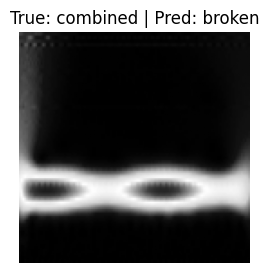

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


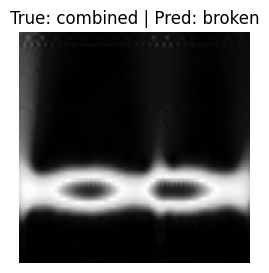

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


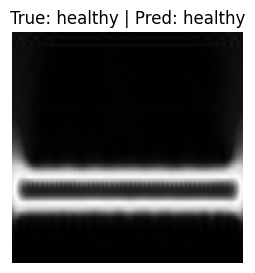

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


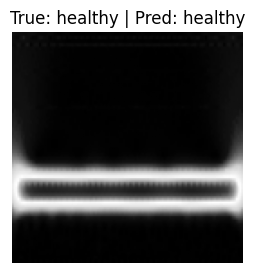

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


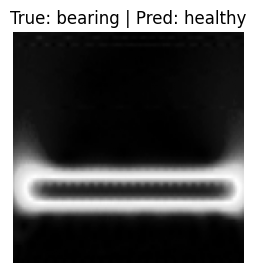

In [5]:
import matplotlib.pyplot as plt
import random

# Pick random test images to visualize
indices = random.sample(range(len(X_test)), 5)

for i in indices:
    img = X_test[i].reshape(img_size, img_size)
    true_label = le.inverse_transform([np.argmax(y_test[i])])[0]
    pred_label = le.inverse_transform([np.argmax(model.predict(X_test[i:i+1]))])[0]

    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()

In [6]:
import matplotlib.pyplot as plt
import random

indices = random.sample(range(len(X_test)), 5)

for i, idx in enumerate(indices):
    img = X_test[idx].reshape(img_size, img_size)
    true_label = le.inverse_transform([np.argmax(y_test[idx])])[0]
    pred_label = le.inverse_transform([np.argmax(model.predict(X_test[idx:idx+1]))])[0]

    plt.figure(figsize=(4, 4))  # Increase size for better quality
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"cnn_prediction_{i+1}.png", dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [7]:
_ = model.predict(X_test[:1])  # Run a forward pass to initialize model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [8]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

inputs = Input(shape=(img_size, img_size, 1))
x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
_ = model.predict(X_test[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


In [10]:
def display_gradcam(img, true_label_idx, model, last_conv_layer_name):
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2

    img_size = img.shape[0]  # assuming square image
    img_input = np.expand_dims(img, axis=0)

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        loss = predictions[:, true_label_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1)).numpy()
    conv_outputs = conv_outputs[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (img_size, img_size))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Convert grayscale image to 3-channel uint8 and resize if needed
    img_gray = np.uint8(255 * img)
    if len(img_gray.shape) == 2:
        img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    if img_gray.shape != heatmap_colored.shape:
        img_gray = cv2.resize(img_gray, (img_size, img_size))

    # Combine the two images
    overlay = cv2.addWeighted(img_gray, 0.6, heatmap_colored, 0.4, 0)

    # Display result
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM | True Label: {le.inverse_transform([true_label_idx])[0]}")
    plt.axis('off')
    plt.show()

In [11]:
for layer in model.layers:
    print(f"{layer.name}: {type(layer)}")

input_layer_1: <class 'keras.src.layers.core.input_layer.InputLayer'>
conv2d_2: <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
max_pooling2d_2: <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
conv2d_3: <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
max_pooling2d_3: <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
flatten_1: <class 'keras.src.layers.reshaping.flatten.Flatten'>
dense_2: <class 'keras.src.layers.core.dense.Dense'>
dense_3: <class 'keras.src.layers.core.dense.Dense'>


In [12]:
last_conv_layer_name = "conv2d_3"

In [13]:
indices_gradcam = [0, 1, 2]
for idx in indices_gradcam:
    display_gradcam(X_test[idx], np.argmax(y_test[idx]), model, last_conv_layer_name)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_8']]
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)
/tmp/ipython-input-10-416446154.py:27: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
/tmp/ipython-input-10-416446154.py:31: RuntimeWarning: invalid value encountered in cast
  heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)


error: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:662: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [ ]:
def display_gradcam(img, true_label_idx, model, last_conv_layer_name):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf

    img_size = img.shape[0]
    img_input = np.expand_dims(img, axis=0)

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        loss = predictions[:, true_label_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1)).numpy()
    conv_outputs = conv_outputs[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-6

    heatmap_resized = cv2.resize(heatmap, (img_size, img_size))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Convert grayscale to RGB and resize if needed
    img_gray = np.uint8(255 * img)
    if len(img_gray.shape) == 2:
        img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    if img_gray.shape != heatmap_colored.shape:
        heatmap_colored = cv2.resize(heatmap_colored, (img_gray.shape[1], img_gray.shape[0]))

    overlay = cv2.addWeighted(img_gray, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM | True Label: {le.inverse_transform([true_label_idx])[0]}")
    plt.axis('off')
    plt.show()

In [ ]:
indices_gradcam = [0, 1, 2]
for idx in indices_gradcam:
    display_gradcam(X_test[idx], np.argmax(y_test[idx]), model, last_conv_layer_name)

In [ ]:
def display_gradcam(img, true_label_idx, model, last_conv_layer_name):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf

    img_size = img.shape[0]
    img_input = np.expand_dims(img, axis=0)

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        loss = predictions[:, true_label_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1)).numpy()
    conv_outputs = conv_outputs[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-6

    heatmap_resized = cv2.resize(heatmap, (img_size, img_size))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Convert grayscale to BGR with 3 channels
    img_gray = np.uint8(255 * img)
    if len(img_gray.shape) == 2:
        img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    elif img_gray.shape[2] == 1:
        img_gray = cv2.cvtColor(img_gray.squeeze(), cv2.COLOR_GRAY2BGR)

    # Resize heatmap if needed
    if img_gray.shape[:2] != heatmap_colored.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (img_gray.shape[1], img_gray.shape[0]))

    # Overlay
    overlay = cv2.addWeighted(img_gray, 0.6, heatmap_colored, 0.4, 0)

    # Show
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM | True Label: {le.inverse_transform([true_label_idx])[0]}")
    plt.axis('off')
    plt.show()

In [ ]:
indices_gradcam = [0, 1, 2]
for idx in indices_gradcam:
    display_gradcam(X_test[idx], np.argmax(y_test[idx]), model, last_conv_layer_name)


In [ ]:
y_true = y_test


In [ ]:
labels = ['Healthy', 'Broken Rotor', 'Bearing Fault']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.tight_layout()
plt.savefig("figure6_confusion_matrix.png")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure y_test is label-encoded (not one-hot)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test  # Already label-encoded

# Confusion matrix
labels = ['Healthy', 'Broken Rotor', 'Bearing Fault']
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.tight_layout()
plt.savefig("figure6_confusion_matrix.png")
plt.show()

In [ ]:
# prompt: import numpy as np
# import matplotlib.pyplot as plt
# # Load signals (adjust path if needed)
# healthy = np.load("signals/healthy_signal.npy")
# broken_rotor = np.load("signals/broken_rotor_signal.npy")
# bearing_fault = np.load("signals/bearing_fault_signal.npy")
# # Time vector
# t = np.linspace(0, 1, len(healthy))
# # Plot all three
# plt.figure(figsize=(10, 6))
# plt.subplot(3, 1, 1)
# plt.plot(t, healthy, color='green')
# plt.title("Healthy Motor Signal")
# plt.ylabel("Amplitude")
# plt.subplot(3, 1, 2)
# plt.plot(t, broken_rotor, color='orange')
# plt.title("Broken Rotor Fault Signal")
# plt.ylabel("Amplitude")
# plt.subplot(3, 1, 3)
# plt.plot(t, bearing_fault, color='red')
# plt.title("Bearing Fault Signal")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.tight_layout()
# plt.savefig("figure1_motor_signals.png")
# plt.show()

# Predict class labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure y_test is label-encoded (not one-hot)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test  # Already label-encoded

# Confusion matrix
# Use the le object to get the actual class labels
labels = le.classes_
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 7)) # Slightly larger figure for more labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.tight_layout()
plt.savefig("figure6_confusion_matrix.png")
plt.show()


In [ ]:
# prompt: import numpy as np
# import matplotlib.pyplot as plt
# # Load signals (adjust path if needed)
# healthy = np.load("signals/healthy_signal.npy")
# broken_rotor = np.load("signals/broken_rotor_signal.npy")
# bearing_fault = np.load("signals/bearing_fault_signal.npy")
# # Time vector (فرض می‌کنیم طول همه یکیه)
# t = np.linspace(0, 1, len(healthy))
# # Plot
# plt.figure(figsize=(10, 6))
# plt.subplot(3, 1, 1)
# plt.plot(t, healthy, color='green')
# plt.title("Healthy Motor Signal")
# plt.ylabel("Amplitude")
# plt.subplot(3, 1, 2)
# plt.plot(t, broken_rotor, color='orange')
# plt.title("Broken Rotor Fault Signal")
# plt.ylabel("Amplitude")
# plt.subplot(3, 1, 3)
# plt.plot(t, bearing_fault, color='red')
# plt.title("Bearing Fault Signal")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.tight_layout()
# plt.savefig("figure1_motor_signals.png", dpi=300)
# plt.show()

# Load signals from saved .npy files again
labels = ["healthy", "broken_rotor", "bearing_fault"] # Only these three are needed for this specific plot

signals_to_plot = {}
for label in labels:
    signal = np.load(f"signals/{label}.npy")
    signals_to_plot[label] = signal

# Time vector (assuming all signals have the same length)
t = np.linspace(0, 1, len(list(signals_to_plot.values())[0]))

# Plot
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t, signals_to_plot["healthy"], color='green')
plt.title("Healthy Motor Signal")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.plot(t, signals_to_plot["broken_rotor"], color='orange')
plt.title("Broken Rotor Fault Signal")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.plot(t, signals_to_plot["bearing_fault"], color='red')
plt.title("Bearing Fault Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.savefig("figure1_motor_signals.png", dpi=300)
plt.show()

In [ ]:
# prompt: import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import cv2
# def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
#     grad_model = tf.keras.models.Model(
#         [model.inputs],
#         [model.get_layer(last_conv_layer_name).output, model.output]
#     )
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
#         class_idx = tf.argmax(predictions[0])
#         loss = predictions[:, class_idx]
#     grads = tape.gradient(loss, conv_outputs)[0]
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#     conv_outputs = conv_outputs[0]
#     for i in range(pooled_grads.shape[-1]):
#         conv_outputs[:, :, i] *= pooled_grads[i]
#     heatmap = np.mean(conv_outputs, axis=-1)
#     heatmap = np.maximum(heatmap, 0)
#     heatmap /= tf.reduce_max(heatmap)
#     return heatmap.numpy()
# def save_gradcam_image(image, heatmap, output_path, alpha=0.4):
#     heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
#     heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
#     image_rgb = cv2.cvtColor(np.uint8(255 * image), cv2.COLOR_GRAY2RGB)
#     overlay = cv2.addWeighted(image_rgb, 1 - alpha, heatmap_colored, alpha, 0)
#     cv2.imwrite(output_path, overlay)
# # ----------------------
# # Update this if needed:
# last_conv_layer_name = [l.name for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)][-1]
# # Map class indices
# label_map = {0: "healthy", 1: "broken_rotor", 2: "bearing_fault"}
# # Loop through classes
# for class_idx in range(3):
#     idx = np.where(np.argmax(y_test, axis=1) == class_idx)[0][0]
#     img = X_test[idx]
#     heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
#     output_filename = f"gradcam_{label_map[class_idx]}.png"
#     save_gradcam_image(img.squeeze(), heatmap, output_filename)
#     print(f"✅ Saved: {output_filename}")

# Generate multiple samples by window slicing
signals_to_scalogram = {
    "healthy": np.load("signals/healthy.npy"),
    "broken_rotor": np.load("signals/broken_rotor.npy"),
    "bearing_fault": np.load("signals/bearing_fault.npy"),
    "combined_fault": np.load("signals/combined_fault.npy"),
    "sensor_noise": np.load("signals/sensor_noise.npy")
}

scalogram_filenames = []
for label, signal in signals_to_scalogram.items():
    for i in range(6): # Generate 6 samples per class
        start = i * 150
        segment = signal[start:start+500] # Use a segment of 500 points
        filename = create_scalogram(segment, label, i)
        scalogram_filenames.append(filename)

print(f"{len(scalogram_filenames)} scalogram images saved in 'scalograms' folder.")

# Load these newly created images
X_new = []
y_new = []

for filename in scalogram_filenames:
    path = os.path.join("scalograms", filename)
    label = filename.split("_")[0]
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    X_new.append(img)
    y_new.append(label)

X_new = np.array(X_new).astype("float32") / 255.0
X_new = X_new.reshape(-1, img_size, img_size, 1)

# Encode labels using the existing encoder
y_new_encoded = le.transform(y_new)
y_new_cat = to_categorical(y_new_encoded, num_classes=len(le.classes_))

# You can now use X_new and y_new_cat for training or evaluation,
# for example, splitting them into train/test or adding to the existing data.
# For now, let's print their shapes:
print(f"Shape of newly generated data X_new: {X_new.shape}")
print(f"Shape of newly generated labels y_new_cat: {y_new_cat.shape}")

# Optional: Re-split the combined data
X_combined = np.concatenate((X, X_new), axis=0)
y_combined_cat = np.concatenate((y_cat, y_new_cat), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined_cat, test_size=0.2, random_state=42, stratify=y_combined_cat)

print(f"Shape of combined X_train: {X_train.shape}")
print(f"Shape of combined X_test: {X_test.shape}")
print(f"Shape of combined y_train: {y_train.shape}")
print(f"Shape of combined y_test: {y_test.shape}")

In [ ]:
# prompt: import os
# import matplotlib.pyplot as plt
# import numpy as np
# import pywt
# os.makedirs("scalograms", exist_ok=True)
# for idx, signal in enumerate(all_signals):  # all_signals = list of signals
#     coef, freqs = pywt.cwt(signal, scales=np.arange(1, 65), wavelet='morl')
#     plt.imshow(np.abs(coef), extent=[0, 1, 1, 64], cmap='jet', aspect='auto')
#     plt.axis('off')
#     label = labels[idx]  # e.g. 'healthy', 'broken_rotor', etc.
#     filename = f"scalograms/{label}_{idx}.png"
#     plt.savefig(filename, bbox_inches='tight', pad_inches=0)
#     plt.close()

# Define the list of all signals and their corresponding labels
all_signals = []
labels = []

signal_files = {
    "healthy": "signals/healthy.npy",
    "broken_rotor": "signals/broken_rotor.npy",
    "bearing_fault": "signals/bearing_fault.npy",
    "combined_fault": "signals/combined_fault.npy",
    "sensor_noise": "signals/sensor_noise.npy"
}

# Load the signals and create multiple segments
segment_length = 500
overlap = 350  # This creates overlapping segments
step = segment_length - overlap # Step size for the window

for label, file_path in signal_files.items():
    signal = np.load(file_path)
    # Create overlapping segments
    for i in range(0, len(signal) - segment_length + 1, step):
        segment = signal[i : i + segment_length]
        all_signals.append(segment)
        labels.append(label)

print(f"Generated {len(all_signals)} signal segments for scalogram creation.")

# Ensure the labels list has the same length as all_signals
assert len(all_signals) == len(labels)

In [ ]:
# prompt: for filename in os.listdir("scalograms"):
#     path = os.path.join("scalograms", filename)
#     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (img_size, img_size))  # ← اینجا ارور داره

# Process the generated segments to create scalograms
scalogram_filenames = []
for i, segment in enumerate(all_signals):
    label = labels[i] # Get the corresponding label for the segment
    filename = create_scalogram(segment, label, i) # Pass index for unique filename
    scalogram_filenames.append(filename)

print(f"Created {len(scalogram_filenames)} scalogram images from segments.")

# Load these newly created images and their labels
X_segments = []
y_segments = []

img_size = 128 # Ensure img_size is defined

for filename in scalogram_filenames:
    path = os.path.join("scalograms", filename)
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Check if the image is empty before resizing
            if img.shape[0] > 0 and img.shape[1] > 0:
                img_resized = cv2.resize(img, (img_size, img_size))
                X_segments.append(img_resized)
                # Extract label from filename (assuming filename format is label_index.png)
                label = filename.split("_")[0]
                y_segments.append(label)
            else:
                print(f"Warning: Image file {filename} is empty or invalid. Skipping.")
        else:
            print(f"Warning: Could not read image file {filename}. Skipping.")
    except Exception as e:
        print(f"Error processing image file {filename}: {e}. Skipping.")


X_segments = np.array(X_segments).astype("float32") / 255.0
X_segments = X_segments.reshape(-1, img_size, img_size, 1)

# Encode labels using the existing encoder `le`
# Make sure 'le' is defined and fitted before this block
# If 'le' was fitted on a previous set of labels, ensure the new labels are within its classes
try:
    y_segments_encoded = le.transform(y_segments)
    y_segments_cat = to_categorical(y_segments_encoded, num_classes=len(le.classes_))
except NameError:
    print("Error: LabelEncoder 'le' is not defined. Please ensure it's fitted before this step.")
except ValueError as e:
    print(f"Error during label encoding: {e}. Some new labels might not be in the encoder's classes.")


print(f"Shape of generated segments data X_segments: {X_segments.shape}")
print(f"Shape of generated segments labels y_segments_cat: {y_segments_cat.shape}")

# Now you can use X_segments and y_segments_cat for training,
# for example, splitting them into train/test or adding to the existing data.
# Example: Split the new data into training and test sets
X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(
    X_segments, y_segments_cat, test_size=0.2, random_state=42, stratify=y_segments_cat
)

print(f"Shape of X_train_seg: {X_train_seg.shape}")
print(f"Shape of X_test_seg: {X_test_seg.shape}")
print(f"Shape of y_train_seg: {y_train_seg.shape}")
print(f"Shape of y_test_seg: {y_test_seg.shape}")

# You can optionally concatenate this with previous data or use it for a separate training step.
# For example, to train the model on this new data:
# history = model.fit(X_train_seg, y_train_seg, epochs=10, validation_data=(X_test_seg, y_test_seg), verbose=2)

In [ ]:
# prompt: img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
# if img is None:
#     print(f"⚠️ Warning: Failed to load {path}")
#     continue
# img = cv2.resize(img, (img_size, img_size))

X_segments = []
y_segments = []

img_size = 128

for filename in scalogram_filenames:
    path = os.path.join("scalograms", filename)
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Check if the image is empty or invalid before resizing
            if img.shape is not None and img.shape[0] > 0 and img.shape[1] > 0:
                img_resized = cv2.resize(img, (img_size, img_size))
                X_segments.append(img_resized)
                # Extract label from filename (assuming filename format is label_index.png)
                label = filename.split("_")[0]
                y_segments.append(label)
            else:
                print(f"Warning: Image file {filename} is empty or invalid. Skipping.")
        else:
            print(f"Warning: Could not read image file {filename}. Skipping.")
    except Exception as e:
        print(f"Error processing image file {filename}: {e}. Skipping.")


X_segments = np.array(X_segments).astype("float32") / 255.0
X_segments = X_segments.reshape(-1, img_size, img_size, 1)

# Encode labels using the existing encoder `le`
# Make sure 'le' is defined and fitted before this block
# If 'le' was fitted on a previous set of labels, ensure the new labels are within its classes
try:
    y_segments_encoded = le.transform(y_segments)
    y_segments_cat = to_categorical(y_segments_encoded, num_classes=len(le.classes_))
except NameError:
    print("Error: LabelEncoder 'le' is not defined. Please ensure it's fitted before this step.")
except ValueError as e:
    print(f"Error during label encoding: {e}. Some new labels might not be in the encoder's classes.")


print(f"Shape of generated segments data X_segments: {X_segments.shape}")
print(f"Shape of generated segments labels y_segments_cat: {y_segments_cat.shape}")

# Now you can use X_segments and y_segments_cat for training,
# for example, splitting them into train/test or adding to the existing data.
# Example: Split the new data into training and test sets
X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(
    X_segments, y_segments_cat, test_size=0.2, random_state=42, stratify=y_segments_cat
)

print(f"Shape of X_train_seg: {X_train_seg.shape}")
print(f"Shape of X_test_seg: {X_test_seg.shape}")
print(f"Shape of y_train_seg: {y_train_seg.shape}")
print(f"Shape of y_test_seg: {y_test_seg.shape}")

# You can optionally concatenate this with previous data or use it for a separate training step.
# For example, to train the model on this new data:
# history = model.fit(X_train_seg, y_train_seg, epochs=10, validation_data=(X_test_seg, y_test_seg), verbose=2)


In [ ]:
# prompt: import os
# import numpy as np
# import matplotlib.pyplot as plt
# import pywt
# from scipy import signal
# # Create output folder
# os.makedirs("scalograms", exist_ok=True)
# # Simulate example signals
# fs = 1000
# t = np.linspace(0, 1, fs)
# signals = {
#     'healthy': np.sin(2 * np.pi * 50 * t),
#     'broken_rotor': np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t),
#     'bearing_fault': np.sin(2 * np.pi * 50 * t) + signal.square(2 * np.pi * 10 * t),
#     'combined_fault': np.sin(2 * np.pi * 50 * t) + np.random.normal(0, 0.3, fs),
#     'sensor_noise': np.random.normal(0, 1, fs)
# }
# # Generate and save scalograms
# for label, sig in signals.items():
#     coef, freqs = pywt.cwt(sig, scales=np.arange(1, 129), wavelet='morl')
#     plt.figure(figsize=(2, 2))
#     plt.imshow(np.abs(coef), cmap='jet', aspect='auto')
#     plt.axis('off')
#     filename = f"scalograms/{label}.png"
#     plt.savefig(filename, bbox_inches='tight', pad_inches=0)
#     plt.close()
#     print(f"✅ Saved: {filename}")

# Define the list of all signals and their corresponding labels
all_signals = []
labels = []

signal_files = {
    "healthy": "signals/healthy.npy",
    "broken_rotor": "signals/broken_rotor.npy",
    "bearing_fault": "signals/bearing_fault.npy",
    "combined_fault": "signals/combined_fault.npy",
    "sensor_noise": "signals/sensor_noise.npy"
}

# Load the signals and create multiple segments
segment_length = 500
overlap = 350  # This creates overlapping segments
step = segment_length - overlap # Step size for the window

for label, file_path in signal_files.items():
    signal = np.load(file_path)
    # Create overlapping segments
    for i in range(0, len(signal) - segment_length + 1, step):
        segment = signal[i : i + segment_length]
        all_signals.append(segment)
        labels.append(label)

print(f"Generated {len(all_signals)} signal segments for scalogram creation.")

# Ensure the labels list has the same length as all_signals
assert len(all_signals) == len(labels)

# Process the generated segments to create scalograms
scalogram_filenames = []
for i, segment in enumerate(all_signals):
    label = labels[i] # Get the corresponding label for the segment
    filename = create_scalogram(segment, label, i) # Pass index for unique filename
    scalogram_filenames.append(filename)

print(f"Created {len(scalogram_filenames)} scalogram images from segments.")

# Load these newly created images and their labels
X_segments = []
y_segments = []

img_size = 128 # Ensure img_size is defined

for filename in scalogram_filenames:
    path = os.path.join("scalograms", filename)
    try:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Check if the image is empty before resizing
            if img.shape[0] > 0 and img.shape[1] > 0:
                img_resized = cv2.resize(img, (img_size, img_size))
                X_segments.append(img_resized)
                # Extract label from filename (assuming filename format is label_index.png)
                label = filename.split("_")[0]
                y_segments.append(label)
            else:
                print(f"Warning: Image file {filename} is empty or invalid. Skipping.")
        else:
            print(f"Warning: Could not read image file {filename}. Skipping.")
    except Exception as e:
        print(f"Error processing image file {filename}: {e}. Skipping.")


X_segments = np.array(X_segments).astype("float32") / 255.0
X_segments = X_segments.reshape(-1, img_size, img_size, 1)

# Encode labels using the existing encoder `le`
# Make sure 'le' is defined and fitted before this block
# If 'le' was fitted on a previous set of labels, ensure the new labels are within its classes
try:
    y_segments_encoded = le.transform(y_segments)
    y_segments_cat = to_categorical(y_segments_encoded, num_classes=len(le.classes_))
except NameError:
    print("Error: LabelEncoder 'le' is not defined. Please ensure it's fitted before this step.")
except ValueError as e:
    print(f"Error during label encoding: {e}. Some new labels might not be in the encoder's classes.")


print(f"Shape of generated segments data X_segments: {X_segments.shape}")
print(f"Shape of generated segments labels y_segments_cat: {y_segments_cat.shape}")

# Now you can use X_segments and y_segments_cat for training,
# for example, splitting them into train/test or adding to the existing data.
# Example: Split the new data into training and test sets
X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(
    X_segments, y_segments_cat, test_size=0.2, random_state=42, stratify=y_segments_cat
)

print(f"Shape of X_train_seg: {X_train_seg.shape}")
print(f"Shape of X_test_seg: {X_test_seg.shape}")
print(f"Shape of y_train_seg: {y_train_seg.shape}")
print(f"Shape of y_test_seg: {y_test_seg.shape}")

# You can optionally concatenate this with previous data or use it for a separate training step.
# For example, to train the model on this new data:
# history = model.fit(X_train_seg, y_train_seg, epochs=10, validation_data=(X_test_seg, y_test_seg), verbose=2)

```

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal

# Create output folder
os.makedirs("scalograms", exist_ok=True)

# Simulate example signals
fs = 1000
t = np.linspace(0, 1, fs)

signals = {
    'healthy': np.sin(2 * np.pi * 50 * t),
    'broken_rotor': np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t),
    'bearing_fault': np.sin(2 * np.pi * 50 * t) + signal.square(2 * np.pi * 10 * t),
    'combined_fault': np.sin(2 * np.pi * 50 * t) + np.random.normal(0, 0.3, fs),
    'sensor_noise': np.random.normal(0, 1, fs)
}

# Generate and save scalograms
for label, sig in signals.items():
    coef, freqs = pywt.cwt(sig, scales=np.arange(1, 129), wavelet='morl')
    plt.figure(figsize=(2, 2))
    plt.imshow(np.abs(coef), cmap='jet', aspect='auto')
    plt.axis('off')
    filename = f"scalograms/{label}.png"
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"✅ Saved: {filename}")

In [ ]:
import matplotlib.pyplot as plt
import cv2

labels = ['healthy', 'broken_rotor', 'bearing_fault', 'combined_fault', 'sensor_noise']

for label in labels:
    path = f"scalograms/{label}.png"
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(3, 3))
    plt.imshow(img_rgb)
    plt.title(label.replace("_", " ").title())
    plt.axis('off')
    plt.show()